In [1]:
#imprt libraries
import numpy as np
import pandas as pd
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from keras.models import Sequential
from keras.layers import LSTM, Dense

In [2]:
#import training and testing data sets
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('Test_Jan.csv')

In [3]:
#convert date column to datetime format
train_df['Date'] = pd.to_datetime(train_df['datetime'], format='%d-%m-%Y %H:%M')
test_df['Date'] = pd.to_datetime(test_df['datetime'], format='%d-%m-%Y %H:%M')

In [4]:
#create a new data frame using necessary columns from the original data frame
columns = ['datetime','nat_demand','T2M_toc','T2M_san','T2M_dav']
train_df = pd.DataFrame(train_df[columns])
test_df = pd.DataFrame(test_df[columns])

In [5]:
#standardize the data 
scaler = StandardScaler()
target_scaler = StandardScaler()
target_scaler.fit(train_df[['nat_demand']])
train_df[columns[1:]] = scaler.fit_transform(train_df[columns[1:]])
test_df[columns[1:]] = scaler.transform(test_df[columns[1:]]) #use same mean and variance as training data

In [6]:
#select principal components
clms = ['T2M_toc','T2M_san','T2M_dav']
pca = PCA(n_components=2)
pca = pca.fit(train_df[clms])
train_df['pca1'] = pca.transform(train_df[clms])[:,0]
test_df['pca1'] = pca.transform(test_df[clms])[:,0] #use same mean and variance as training data

In [7]:
#setup the input data for model training
features = ['nat_demand','pca1']
window_size = 10
X_train = []
y_train = []
X_test = []
y_test = []

for i in range(len(train_df)-window_size):
    X_train.append(train_df[features].iloc[i:i+window_size].values)
    y_train.append(train_df['nat_demand'][i+window_size])
X_train = np.array(X_train)
y_train = np.array(y_train)

for j in range(len(test_df)-window_size):
    X_test.append(test_df[features].iloc[j:j+window_size].values)
    y_test.append(test_df['nat_demand'][j+window_size])
X_test = np.array(X_test)
y_test = np.array(y_test)


In [8]:
model = Sequential([
    LSTM(50, activation='tanh', input_shape=(window_size, 2)),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')
model.summary()

c:\Users\asus\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 50)             │        10,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,651 (41.61 KB)

 Trainable params: 10,651 (41.61 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
model.fit(X_train, y_train, epochs=10, batch_size=16)

Epoch 1/10
2736/2736 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 0.1137
Epoch 2/10
2736/2736 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 0.0211
Epoch 3/10
2736/2736 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 0.0186
Epoch 4/10
2736/2736 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - loss: 0.0170
Epoch 5/10
2736/2736 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - loss: 0.0176
Epoch 6/10
2736/2736 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 0.0157
Epoch 7/10
2736/2736 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 0.0135
Epoch 8/10
2736/2736 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 0.0144
Epoch 9/10
2736/2736 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - loss: 0.0171
Epoch 10/10
2736/2736 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 0.0168


In [10]:
#make predictions
predictions = model.predict(X_test)

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


In [11]:
predictions.shape

(734, 1)

In [15]:
reshaped_predictions = predictions.reshape(-1,1)
reshaped_predictions.shape

(734, 1)

In [16]:

predicted_values = target_scaler.inverse_transform(reshaped_predictions)

In [17]:
predicted_values.shape

(734, 1)

In [29]:
a = np.concatenate((X_train[-window_size:], X_test), axis=0)


In [ ]:
#make predictions
predictions_2020 = model.predict(a)
reshaped_predictions_2020 = predictions_2020.reshape(-1,1)
predicted_values_2020 = target_scaler.inverse_transform(reshaped_predictions_2020)


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [35]:
actual_df = pd.read_csv('Predict_Jan.csv')
actual_df.head()

,datetime,nat_demand
0,01-01-2020 00:00,1032.2630
1,01-01-2020 01:00,1017.5806
2,01-01-2020 02:00,1000.2797
3,01-01-2020 03:00,987.2383
4,01-01-2020 04:00,970.3667


In [38]:
actual_df['predicted_demand'] = predicted_values_2020

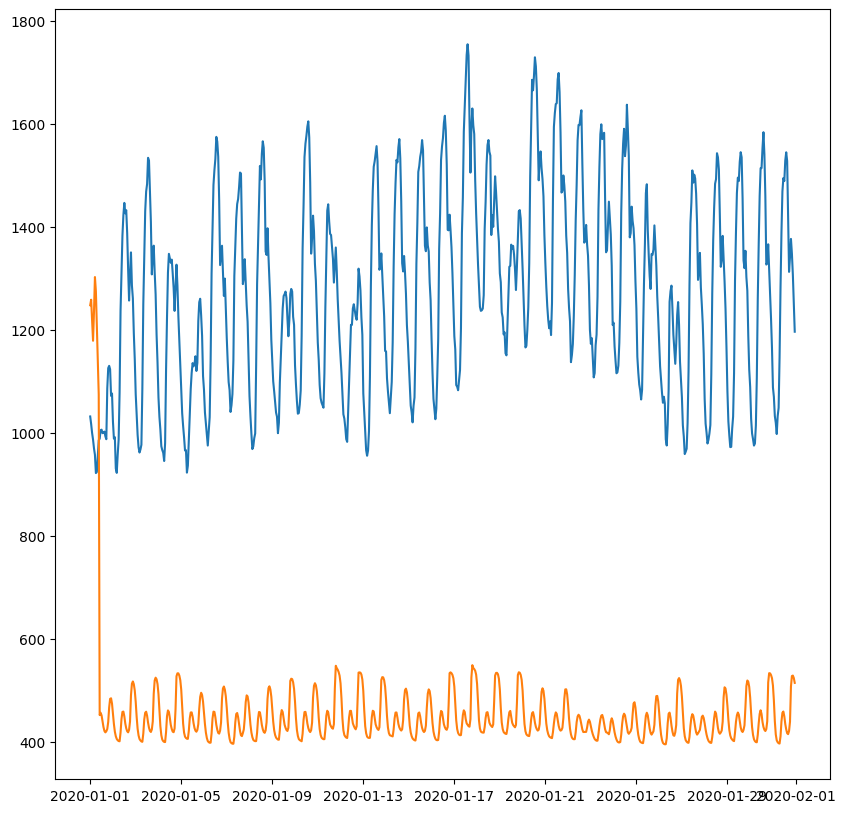

In [42]:
#plot actual with predicted
actual_df['datetime'] = pd.to_datetime(actual_df['datetime'],format='%d-%m-%Y %H:%M')
plt.figure(figsize=(10,10))
plt.plot(actual_df['datetime'],actual_df['nat_demand'])
plt.plot(actual_df['datetime'],actual_df['predicted_demand'])

plt.show()